Integrated Geophysical & Machine Learning Workflow for Carbonate Reservoir Quality Assessment

This notebook demonstrates an integrated geophysical interpretation workflow
designed to emulate deep Middle East carbonate gas reservoirs (Khuff Formation analogue).
The objective is to showcase interpretation logic, uncertainty handling, and
field development decision support rather than field-specific results.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

np.random.seed(7)


In [2]:
# Synthetic Khuff Carbonate Well Logs

depth = np.arange(3800, 4500, 0.5)
n = len(depth)

res_zone = ((depth > 4020) & (depth < 4120)) | ((depth > 4230) & (depth < 4350))

GR = np.where(res_zone, np.random.normal(18,4,n), np.random.normal(35,8,n))
RHOB = np.where(res_zone, np.random.normal(2.55,0.04,n), np.random.normal(2.75,0.03,n))
NPHI = np.where(res_zone, np.random.normal(0.10,0.03,n), np.random.normal(0.03,0.015,n))
DT = np.where(res_zone, np.random.normal(95,6,n), np.random.normal(75,4,n))

well = pd.DataFrame({
    "DEPTH": depth,
    "GR": GR,
    "RHOB": RHOB,
    "NPHI": NPHI,
    "DT": DT
})

well.head()


,DEPTH,GR,RHOB,NPHI,DT
0,3800.0,39.381149,2.750723,0.043466,74.168013
1,3800.5,37.305283,2.768356,0.020598,70.341884
2,3801.0,20.168041,2.726034,0.036714,72.894191
3,3801.5,44.051135,2.734562,0.056504,71.715176
4,3802.0,27.590525,2.718229,0.009075,70.902354


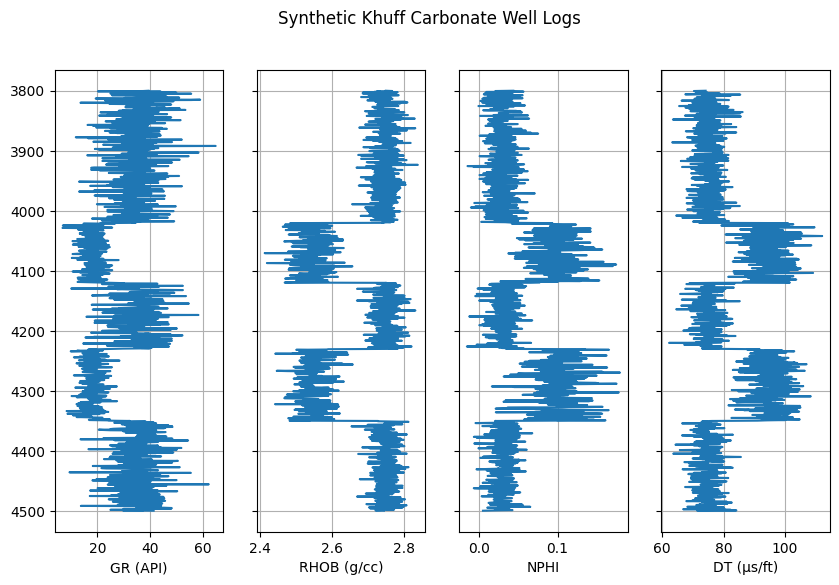

In [3]:
# Well Log Visualization
fig, ax = plt.subplots(1,4, figsize=(10,6), sharey=True)

ax[0].plot(well["GR"], well["DEPTH"]); ax[0].set_xlabel("GR (API)")
ax[1].plot(well["RHOB"], well["DEPTH"]); ax[1].set_xlabel("RHOB (g/cc)")
ax[2].plot(well["NPHI"], well["DEPTH"]); ax[2].set_xlabel("NPHI")
ax[3].plot(well["DT"], well["DEPTH"]); ax[3].set_xlabel("DT (µs/ft)")

for a in ax:
    a.invert_yaxis()
    a.grid(True)

plt.suptitle("Synthetic Khuff Carbonate Well Logs")
plt.gca().invert_yaxis()
plt.show()


In [4]:
#A probabilistic measure of how good the reservoir is, not a binary classification
# The fuzzy RQI function linearly normalizes each log response into a 0–1 membership score based on geological expectations 
# for carbonate reservoirs. This avoids hard cut-offs and allows multiple indicators to jointly represent reservoir quality 
# in an interpretable and uncertainty-aware manner

def fuzzy_rqi(gr, rhob, nphi, dt):
    """
    Fuzzy Reservoir Quality Index (RQI)

    This function computes a probabilistic reservoir quality index (0–1)
    by normalizing key well log responses using geology-driven reference cutoffs.
    The cutoffs are used as soft bounds, not hard thresholds, to reflect
    gradual facies and property transitions in heterogeneous carbonate reservoirs.
    """

    # Gamma Ray (GR)
    # Cutoff reference: ~40 API
    # Rationale:
    # In Middle Eastern carbonate reservoirs, GR values below ~40 API
    # generally indicate relatively clean carbonate lithology, while higher
    # values suggest argillaceous or tight intervals.
    gr_score = np.clip((40 - gr) / 40, 0, 1)

    # Bulk Density (RHOB)
    # Cutoff reference: ~2.75 g/cc, normalization range ~0.4 g/cc
    # Rationale:
    # Carbonate matrix density is around 2.71 g/cc. Values approaching 2.75 g/cc
    # typically represent tight carbonate or anhydrite, while lower densities
    # reflect increasing porosity, including vuggy or fractured carbonates.
    rhob_score = np.clip((2.75 - rhob) / 0.4, 0, 1)

    # Neutron Porosity (NPHI)
    # Cutoff reference: ~0.20 v/v
    # Rationale:
    # Effective porosity in carbonate reservoirs commonly falls below 0.15–0.20 v/v.
    # Using 0.20 as an upper normalization bound ensures realistic carbonate behavior
    # without over-emphasizing anomalously high porosity values.
    nphi_score = np.clip(nphi / 0.2, 0, 1)

    # Sonic Travel Time (DT)
    # Cutoff reference: ~70–110 µs/ft
    # Rationale:
    # Tight carbonates typically show fast sonic velocities (~70 µs/ft),
    # while porous or fractured carbonates exhibit slower velocities.
    # This range captures the transition from tight to reservoir-quality carbonate.
    dt_score = np.clip((dt - 70) / 40, 0, 1)

    # Final Fuzzy RQI
    # Equal weighting is applied to all parameters to maintain transparency
    # and avoid bias toward any single log in early-stage reservoir screening.
    return (gr_score + rhob_score + nphi_score + dt_score) / 4



well["RQI_fuzzy"] = fuzzy_rqi(
    well["GR"], well["RHOB"], well["NPHI"], well["DT"]
)

well[["DEPTH","RQI_fuzzy"]].head()


,DEPTH,RQI_fuzzy
0,3800.0,0.084251
1,3800.5,0.044726
2,3801.0,0.202910
3,3801.5,0.090999
4,3802.0,0.114400


In [5]:
X = well[["GR","RHOB","NPHI","DT"]]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

pca.explained_variance_ratio_


array([0.79967427, 0.10294325])

The PCA results indicate that the first principal component (PC1) explains approximately 80% of the total variance in the well log data, while the second principal component (PC2) accounts for an additional ~10%. This means that over 90% of the geological information contained in the original multi-dimensional log space (GR, RHOB, NPHI, and DT) can be effectively represented by just two components.

From a geophysical perspective, PC1 captures the dominant rock property control, primarily associated with porosity-related responses and reservoir versus tight carbonate contrast. PC2 reflects secondary heterogeneity, which may be related to facies variation, diagenetic effects, or subtle changes in pore structure commonly observed in carbonate reservoirs.

This result demonstrates that the dataset is governed by a small number of meaningful geological drivers, allowing dimensionality reduction without significant information loss. Such simplification is particularly valuable for integrated reservoir studies and field development planning, as it enables robust interpretation while avoiding unnecessary model complexity.

In [6]:
y = well["RQI_fuzzy"]

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3
)

mlp = MLPRegressor(hidden_layer_sizes=(10,10), max_iter=500)
mlp.fit(X_train, y_train)

mlp.score(X_test, y_test)


0.9083101105286568

An R² of 0.9 indicates that the neural network captures the dominant non-linear relationships between geophysical logs and reservoir quality, making it a reliable decision-support tool when used alongside geological interpretation

In [7]:
# Predict RQI on test dataset
y_pred = mlp.predict(X_test)

# Create comparison dataframe
pred_df = pd.DataFrame({
    "RQI_Actual": y_test.values,
    "RQI_Predicted": y_pred
})

pred_df.head()


,RQI_Actual,RQI_Predicted
0,0.102206,0.044992
1,0.109345,0.086096
2,0.171958,0.158563
3,0.133979,0.112605
4,0.497721,0.439842


In [8]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = mlp.score(X_test, y_test)

print(f"R² Score : {r2:.2f}")
print(f"RMSE    : {rmse:.3f}")


R² Score : 0.91
RMSE    : 0.061


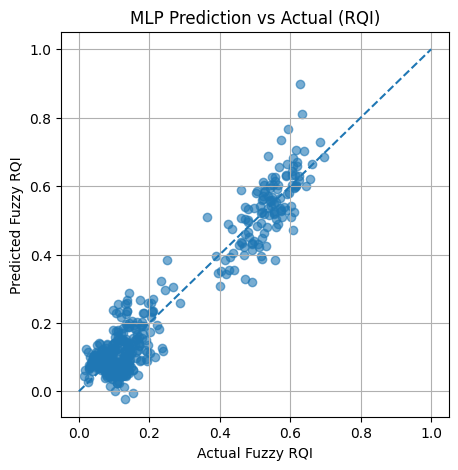

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Actual Fuzzy RQI")
plt.ylabel("Predicted Fuzzy RQI")
plt.title("MLP Prediction vs Actual (RQI)")
plt.grid(True)
plt.show()


In [10]:
# Attach predictions back to depth (for interpretation)
test_index = y_test.index

well.loc[test_index, "RQI_MLP_Pred"] = y_pred

well[["DEPTH","RQI_fuzzy","RQI_MLP_Pred"]].dropna().head()


,DEPTH,RQI_fuzzy,RQI_MLP_Pred
1,3800.5,0.044726,0.076383
3,3801.5,0.090999,0.073343
5,3802.5,0.028020,0.068712
7,3803.5,0.050794,0.088881
9,3804.5,0.197431,0.258958


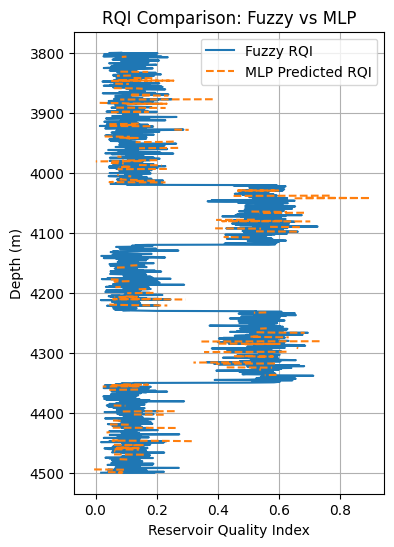

In [11]:
plt.figure(figsize=(4,6))
plt.plot(well["RQI_fuzzy"], well["DEPTH"], label="Fuzzy RQI")
plt.plot(well["RQI_MLP_Pred"], well["DEPTH"], '--', label="MLP Predicted RQI")
plt.gca().invert_yaxis()
plt.xlabel("Reservoir Quality Index")
plt.ylabel("Depth (m)")
plt.title("RQI Comparison: Fuzzy vs MLP")
plt.legend()
plt.grid(True)
plt.show()


“The neural network predicts the fuzzy reservoir quality index with high consistency, confirming that the dominant non-linear relationships in the log data are well captured. The predicted RQI aligns closely with the fuzzy-based interpretation, reinforcing its use as a decision-support tool rather than a standalone classifier.”